<a href="https://colab.research.google.com/github/pthkbs123/SkillTreePython-DeepLearning/blob/main/04.Paper-with-code/ch04_08_Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ch04.08 Transformer

* 날짜: 2022-09-06,07
* 이름: 박태현

## 학습내용
  - Transformer을 이해하고 구현한다.
  - Vision Transformer을 이해하고 구현한다.

## 참고 사이트

   - 논문 [Attention is all you need](https://arxiv.org/pdf/1706.03762.pdf)


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import sys, os
sys.path.append('/content/drive/MyDrive/딥러닝 프레임워크실무/scripts')
from lib import *

## 모듈 제작
---

### **| Multi Head Attention**

<p align='center'>
<img src=https://github.com/yebiny/SkillTreePython-DeepLearning/blob/main/imgs/ch0408-09.PNG?raw=true?raw=true?raw=true
 width=350>
</p>

* set params

<p align='center'>
<img src=https://github.com/yebiny/SkillTreePython-DeepLearning/blob/main/imgs/ch0408-01.PNG?raw=true?raw=true
 width=850>
</p>


In [3]:
h = 8 
d_k = 64
d_v  = 64
d_model = 64 * h #512  = embeding dims

# 인풋 x shape 
# 시계열 : ( time range(window_size), channel )
# 텍스트 : ( max lenth , vocab size )
# 텍스트 임베딩 : (max lenth, embeding dims)

# -> (V, K, Q)
# T = S = max lenth
# d_model = embedding dims
T = 200
S = 100

Q = (T, d_model)
K = (S, d_model)
V = (S, d_model)
print(Q)
print(K)
print(V)

(200, 512)
(100, 512)
(100, 512)


In [4]:
def matmul(shape1, shape2):
  assert shape1[1]==shape2[0]
  return (shape1[0], shape2[1])

* Step1. Linear each  $Q, K, V(W^Q, W^K, W^V)$

<br>

<p align='center'>
<img src=https://github.com/yebiny/SkillTreePython-DeepLearning/blob/main/imgs/ch0408-05.PNG?raw=true?raw=true?raw=true
 width=250>
</p>

<p align='center'>
<img src=https://github.com/yebiny/SkillTreePython-DeepLearning/blob/main/imgs/ch0408-02-1.PNG?raw=true?raw=true
 width=850>
</p>



In [5]:
# set weights
W_Q = (d_model, d_k)
W_K = (d_model, d_k)
W_V = (d_model, d_v) 

# calculate shape
VW = matmul(V, W_V) 
KW = matmul(K, W_K) 
QW = matmul(Q, W_Q) 

print(f'Q {Q} x W_Q {W_Q} = {QW}')
print(f'K {K} x W_K {W_K} = {KW}')
print(f'V {V} x W_V {W_V} = {VW}')

Q (200, 512) x W_Q (512, 64) = (200, 64)
K (100, 512) x W_K (512, 64) = (100, 64)
V (100, 512) x W_V (512, 64) = (100, 64)


* Step2. Attention


<p align='center'>
<img src=https://wikidocs.net/images/page/159310/mha_img_original.png?raw=true
 width=450>
</p>


<p align='center'>
<img src=https://github.com/yebiny/SkillTreePython-DeepLearning/blob/main/imgs/ch0408-03.PNG?raw=true?raw=true
 width=850>
</p>

In [6]:
KW_T = (KW[1], KW[0])
print(f"QW: {QW}, KW_T: {KW_T}, VW: {VW}")

Att = matmul( matmul(QW, KW_T), VW )
print(f'Attention(QW, KW, VW) : {Att}')

QW: (200, 64), KW_T: (64, 100), VW: (100, 64)
Attention(QW, KW, VW) : (200, 64)


* step3. concat & Linear $(W^O)$

<p align='center'>
<img src=https://github.com/yebiny/SkillTreePython-DeepLearning/blob/main/imgs/ch0408-10.PNG?raw=true?raw=true?raw=true
 width=300>
</p>

<p align='center'>
<img src=https://github.com/yebiny/SkillTreePython-DeepLearning/blob/main/imgs/ch0408-04.PNG?raw=true?raw=true
 width=850>
</p>

In [7]:
print(f'- Attention(QW, KW, VW) = head {Att}')

concat_att = (Att[0], Att[1]*h)
print(f'- Concat(head_1, ...head_h) {concat_att}')

W_O = ((h*d_v), d_model)
final_out = matmul(concat_att, W_O)
print(f'- Concat {concat_att} x W_O {W_O} = final output: {final_out}' )

- Attention(QW, KW, VW) = head (200, 64)
- Concat(head_1, ...head_h) (200, 512)
- Concat (200, 512) x W_O (512, 512) = final output: (200, 512)


In [8]:
print('- 인풋: ',  V, K, Q)
print(f'- 최종 아웃풋: {final_out}')

- 인풋:  (100, 512) (100, 512) (200, 512)
- 최종 아웃풋: (200, 512)


#### Tensorflow.keras MultiHeadAttention Layer

* docs: https://www.tensorflow.org/api_docs/python/tf/keras/layers/MultiHeadAttention

```
tf.keras.layers.MultiHeadAttention(
    num_heads,
    key_dim,
    value_dim=None,
)

# call args

query	Query Tensor of shape (B, T, dim).
value	Value Tensor of shape (B, S, dim).
key	Optional key Tensor of shape (B, S, dim). If not given, will use 
```

In [9]:
h = 8 
d_k = 64
d_v  = 64
d_model = 64 * h

T = 200
S = 100


Q = layers.Input(shape = (T, d_model))
V = layers.Input(shape= (S, d_model))

y = layers.MultiHeadAttention(num_heads = h,
                              key_dim = d_k,
                              )(Q,V)


In [11]:
print(f'- 인풋: V {V.shape} K {K.shape} Q {Q.shape}')
print(f'- 최종 아웃풋: {y.shape}')

AttributeError: ignored

### **| Encoder Block**

<p align='center'>
<img src=https://github.com/yebiny/SkillTreePython-DeepLearning/blob/main/imgs/ch0408-11.PNG?raw=true?raw=true
 width=250>
</p>

In [12]:
def encoder_block(Input_shape, h, d_k, d_ff, dropout=0.25, name=None):
    inputs = layers.Input(shape = Input_shape)
    # Attention and Normalization
      # multi-head
    y = layers.MultiHeadAttention(num_heads= h,
                                key_dim = d_k,
                                dropout = dropout)(inputs,inputs)
    y = layers.Dropout(dropout)(y)
    # Add & Norm
    y = layers.LayerNormalization(epsilon=1e-6)(y)
    y_1 = layers.Add()([y, inputs])
    # Feed Forward Part
      # FF
    y = layers.Conv1D(filters=d_ff, kernel_size=1, activation='relu')(y_1)
    y = layers.Dropout(dropout)(y)
    y = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1, activation='relu')(y)
    # Add & Norm
    y = layers.LayerNormalization(epsilon=1e-6)(y)
    outputs = layers.Add()([y,y_1])

    return models.Model(inputs, outputs, name = name)

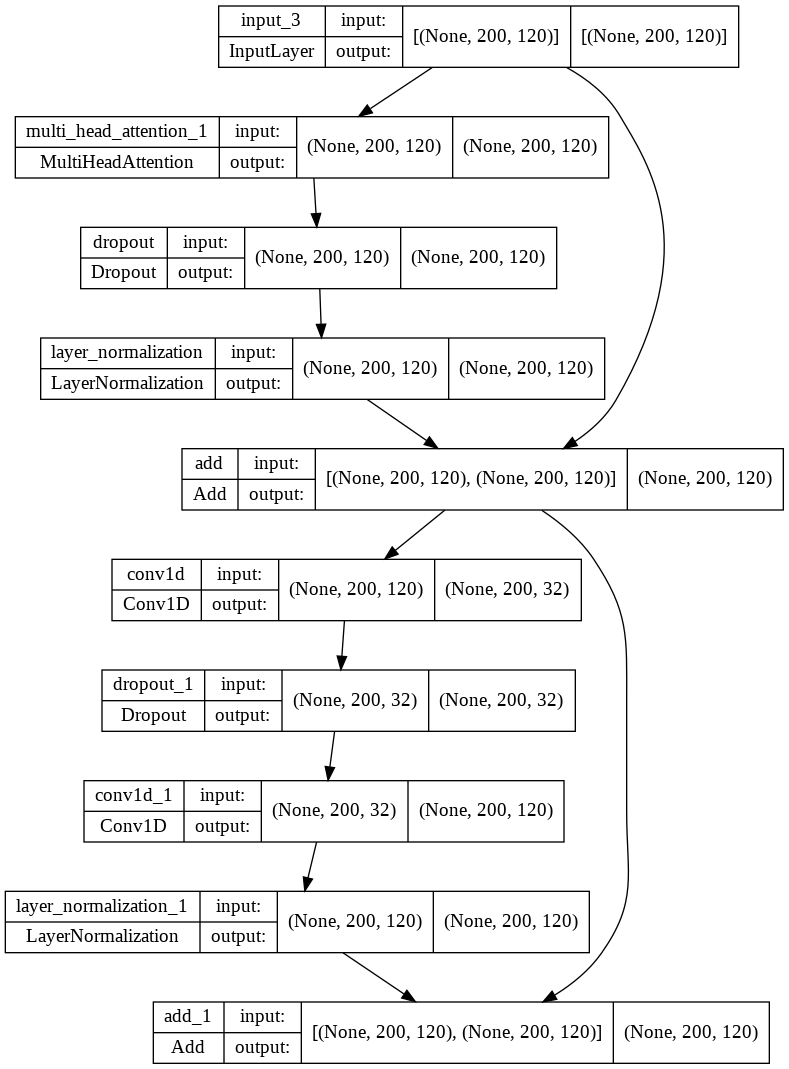

In [13]:
from textwrap import shorten
input_shape = (200,120)
h = 8
d_k = 64
d_ff = 32
encoder = encoder_block(input_shape,
                        h,
                        d_k,
                        d_ff)
utils.plot_model(encoder, show_shapes=True)

## 실습1. 시계열 데이터 분류
---

### **| 시계열 데이터셋**

In [ ]:
def readucr(filename):
    data = np.loadtxt(filename, delimiter="\t")
    y = data[:, 0]
    x = data[:, 1:]
    return x, y.astype(int)


root_url = "https://raw.githubusercontent.com/hfawaz/cd-diagram/master/FordA/"

x_train, y_train = readucr(root_url + "FordA_TRAIN.tsv")
x_test, y_test = readucr(root_url + "FordA_TEST.tsv")

x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

n_classes = len(np.unique(y_train))

idx = np.random.permutation(len(x_train))
x_train = x_train[idx]
y_train = y_train[idx]

y_train[y_train == -1] = 0
y_test[y_test == -1] = 0

(3601, 500, 1) (3601,)


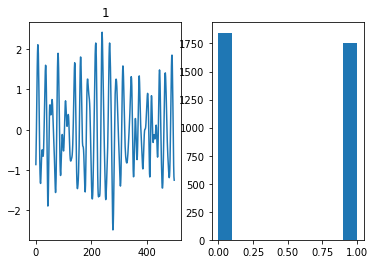

In [ ]:
print(x_train.shape, y_train.shape)

idx = 10
plt.subplot(121)
plt.title(y_train[idx])
plt.plot(x_train[idx])

plt.subplot(122)
plt.hist(y_train)
plt.show()


### **| 모델 구현**

In [ ]:
# Set params
input_shape = (500,1) # ( T/S, d_model )
n_classes = 2
N = 4
h = 4
d_k = 128
d_ff = 4
# Set Input
inputs = layers.Input(shape = input_shape)

# Encoder Block
y = inputs
for i in range(N):
  encoder = encoder_block(input_shape, h, d_k, d_ff, dropout=0.25, name=f'encoder_{i}')
  y = encoder(y)

# Classifier
y = layers.GlobalAveragePooling1D(data_format='channels_first')(y)
y = layers.Dense(128, activation = 'relu')(y)
y = layers.Dropout(0.5)(y)
y = layers.Dense(n_classes, activation = 'softmax')(y)
# Final model
model = models.Model(inputs, y, name = 'TransformerEncoderCfy')
model.summary()

Model: "TransformerEncoderCfy"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_45 (InputLayer)       [(None, 500, 1)]          0         
                                                                 
 encoder_0 (Functional)      (None, 500, 1)            3602      
                                                                 
 encoder_1 (Functional)      (None, 500, 1)            3602      
                                                                 
 encoder_2 (Functional)      (None, 500, 1)            3602      
                                                                 
 encoder_3 (Functional)      (None, 500, 1)            3602      
                                                                 
 global_average_pooling1d_3   (None, 500)              0         
 (GlobalAveragePooling1D)                                        
                                             

In [ ]:
model.compile(loss = 'sparse_categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(0.0001),
              metrics = 'acc')
es = tf.keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True)
model.fit(x_train, y_train,
          validation_data = [x_test, y_test],
          epochs = 50,
          batch_size = 64,
          callbacks=[es])

Epoch 1/50
57/57 [==============================] - 28s 207ms/step - loss: 1.0555 - acc: 0.5171 - val_loss: 0.7381 - val_acc: 0.5811
Epoch 2/50
57/57 [==============================] - 11s 196ms/step - loss: 0.9023 - acc: 0.5587 - val_loss: 0.6752 - val_acc: 0.6030
Epoch 3/50
57/57 [==============================] - 11s 196ms/step - loss: 0.8550 - acc: 0.5818 - val_loss: 0.6400 - val_acc: 0.6371
Epoch 4/50
57/57 [==============================] - 11s 196ms/step - loss: 0.7981 - acc: 0.5996 - val_loss: 0.6146 - val_acc: 0.6576
Epoch 5/50
57/57 [==============================] - 11s 197ms/step - loss: 0.7571 - acc: 0.6209 - val_loss: 0.5994 - val_acc: 0.6735
Epoch 6/50
57/57 [==============================] - 11s 197ms/step - loss: 0.7016 - acc: 0.6423 - val_loss: 0.5863 - val_acc: 0.6818
Epoch 7/50
57/57 [==============================] - 11s 196ms/step - loss: 0.6767 - acc: 0.6582 - val_loss: 0.5729 - val_acc: 0.7038
Epoch 8/50
57/57 [==============================] - 11s 196ms/step - 

## 실습2. IMDB 텍스트 분류
---

### **| IMDB 데이터셋**


In [14]:
vocab_size = 20000  
maxlen = 200  

(x_train, y_train), (x_val, y_val) = tf.keras.datasets.imdb.load_data(num_words=vocab_size)
print(len(x_train), "Training sequences")
print(len(x_val), "Validation sequences")
x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_val = tf.keras.preprocessing.sequence.pad_sequences(x_val, maxlen=maxlen)
print(x_train.shape, x_val.shape)

17473536/17464789 [==============================] - 0s 0us/step
25000 Training sequences
25000 Validation sequences
(25000, 200) (25000, 200)


In [16]:
# 데이터가 정하는 값
maxlen = 200
vocab_size = 20000
# 하이퍼 파라미터
embed_dim = 128

x = layers.Input(shape = (maxlen,))
x_em = layers.Embedding(input_dim = vocab_size, 
                        output_dim = embed_dim)(x)
print(x.shape, x_em.shape)

(None, 200) (None, 200, 128)


In [15]:
class TokenAndPositionEmbedding(layers.Layer): # 상속 : tf.keras.layers
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__() # 부모 클래스 layers
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim) # 기본 임베딩
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim) # positional encoding

    def call(self, x):
        # maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [20]:
# embed = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
# embed(x) # call에 해당하는 부분 실행됨

x_embed = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)(x) # call에 해당하는 부분 실행됨
print(x_embed)

KerasTensor(type_spec=TensorSpec(shape=(None, 200, 128), dtype=tf.float32, name=None), name='token_and_position_embedding_2/add:0', description="created by layer 'token_and_position_embedding_2'")



### **| 모델 구현**

In [23]:
# Set params
maxlen = 200
vocab_size = 20000
embed_dim = 32
n_classes = 2

N = 4
h = 4
d_k = 32
d_ff = 32

# Set Input
inputs = layers.Input(shape = (maxlen,))

# Embeding : maxlen - (maxlen,embed_dim)
y_emb = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)(inputs)

# Encoder Block
y = y_emb
for i in range(N):
  encoder = encoder_block(y.shape[1:], h, d_k, d_ff, dropout=0.25, name=f'encoder_{i}')
  y = encoder(y)

# Classifier
y = layers.GlobalAveragePooling1D(data_format='channels_first')(y)
y = layers.Dense(128, activation = 'relu')(y)
y = layers.Dropout(0.5)(y)
y = layers.Dense(n_classes, activation = 'softmax')(y)
# Final model
model = models.Model(inputs, y, name = 'TransformerEncoderCfy')
model.summary()

Model: "TransformerEncoderCfy"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 200)]             0         
                                                                 
 token_and_position_embeddin  (None, 200, 32)          646400    
 g_3 (TokenAndPositionEmbedd                                     
 ing)                                                            
                                                                 
 encoder_0 (Functional)      (None, 200, 32)           19040     
                                                                 
 encoder_1 (Functional)      (None, 200, 32)           19040     
                                                                 
 encoder_2 (Functional)      (None, 200, 32)           19040     
                                                                 
 encoder_3 (Functional)      (None, 200, 32) 

### **| 학습**

In [26]:
model.compile(loss = 'sparse_categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(0.0001),
              metrics = 'acc')
es = tf.keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True)
model.fit(x_train, y_train,
          validation_data = [x_val, y_val],
          epochs = 50,
          batch_size = 64,
          callbacks=[es])

Epoch 1/50
391/391 [==============================] - 23s 50ms/step - loss: 0.5961 - acc: 0.6564 - val_loss: 0.4127 - val_acc: 0.8272
Epoch 2/50
391/391 [==============================] - 19s 48ms/step - loss: 0.3063 - acc: 0.8733 - val_loss: 0.3175 - val_acc: 0.8627
Epoch 3/50
391/391 [==============================] - 19s 48ms/step - loss: 0.2217 - acc: 0.9138 - val_loss: 0.3883 - val_acc: 0.8554
Epoch 4/50
391/391 [==============================] - 19s 48ms/step - loss: 0.1708 - acc: 0.9380 - val_loss: 0.4085 - val_acc: 0.8632
Epoch 5/50
391/391 [==============================] - 19s 48ms/step - loss: 0.1367 - acc: 0.9524 - val_loss: 0.4151 - val_acc: 0.8589
Epoch 6/50
391/391 [==============================] - 19s 48ms/step - loss: 0.1100 - acc: 0.9633 - val_loss: 0.4718 - val_acc: 0.8648
Epoch 7/50
391/391 [==============================] - 19s 48ms/step - loss: 0.0830 - acc: 0.9748 - val_loss: 0.5524 - val_acc: 0.8597
Epoch 8/50
391/391 [==============================] - 19s 48ms

## 실습3. Vision Transformer
---

In [ ]:
def display_img_patches(img, patches):

  # origin image


  # patches

  # real patches


### **| 이미지 증강**

### **| Patch 생성**

### **| Patch Encoder**


### **| 모델 구현**

In [ ]:
# Set params


# Set Input

# Encoder Block


# Classifier

# Final model
